In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
import cv2
import os

In [17]:
file_path_organic = './DATASET/TRAIN/O/'
file_path_recyclable = './DATASET/TRAIN/R/'

organic_files = os.listdir(file_path_organic)
recyclable_files = os.listdir(file_path_recyclable)

#read in organic images
organic_imgs = []

org_error_count = 0
for img in organic_files:
    image = cv2.imread(file_path_organic + img, cv2.IMREAD_GRAYSCALE)
    try:
        image = cv2.resize(image, dsize=(225,225), interpolation=cv2.INTER_NEAREST)
        organic_imgs.append(image.flatten())
    except:
        org_error_count += 1

organic_imgs = np.array(organic_imgs)
org_target = np.array(['organic'] * organic_imgs.shape[0])

#read in recyclable images
recyclable_imgs = []
rec_error_count = 0
for img in recyclable_files:
    image = cv2.imread(file_path_recyclable + img, cv2.IMREAD_GRAYSCALE)
    try:
        image = cv2.resize(image, dsize=(225,225), interpolation=cv2.INTER_NEAREST)
        recyclable_imgs.append(image.flatten())
    except:
        rec_error_count += 1

recyclable_imgs = np.array(recyclable_imgs)
rec_target = np.array(['recyclable'] * recyclable_imgs.shape[0])

h, w = (225,225)

print("{} Organic images failed to resize".format(org_error_count))
print("Organic Image size:", organic_imgs[0].shape)
print("Organic Image Count:", len(organic_imgs))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("{} Recyclable images failed to resize".format(rec_error_count))
print("Recyclable Image size:", recyclable_imgs[0].shape)
print("Recyclable Image Count:", len(recyclable_imgs))

1 Organic images failed to resize
Organic Image size: (50625,)
Organic Image Count: 12565
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 Recyclable images failed to resize
Recyclable Image size: (50625,)
Recyclable Image Count: 9999


In [3]:
import random
random.seed(1)

# a helper plotting function
def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())

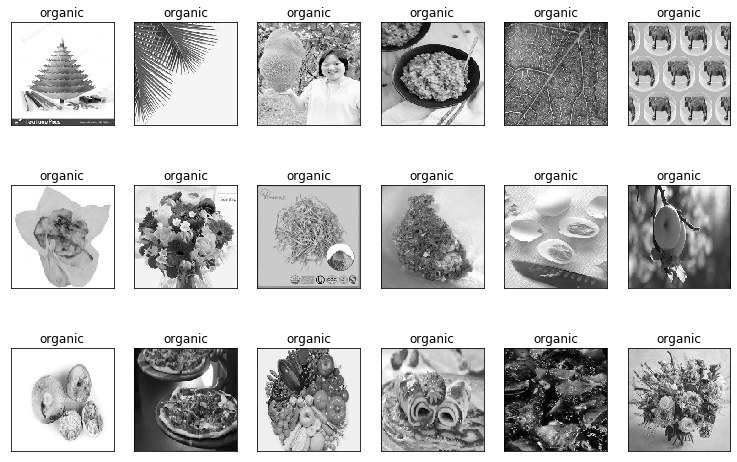

In [18]:
#plot organic images
plot_gallery(organic_imgs, org_target, h, w)

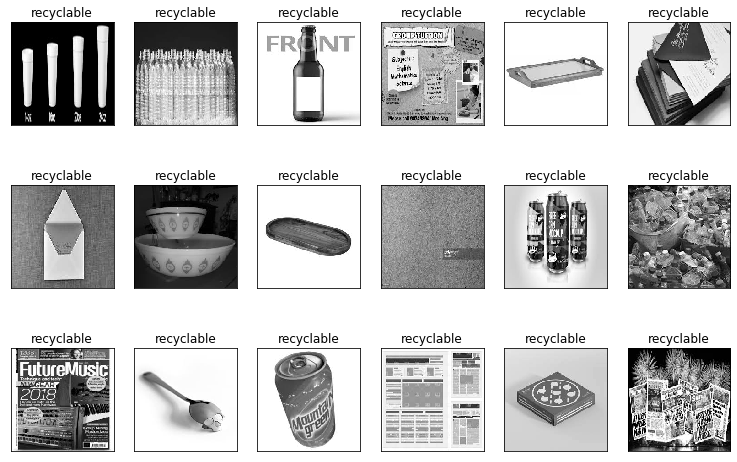

In [19]:
#plot recyclable images
plot_gallery(recyclable_imgs, rec_target, h, w)

X shape:  (3000, 50625)
y shape:  (3000,)


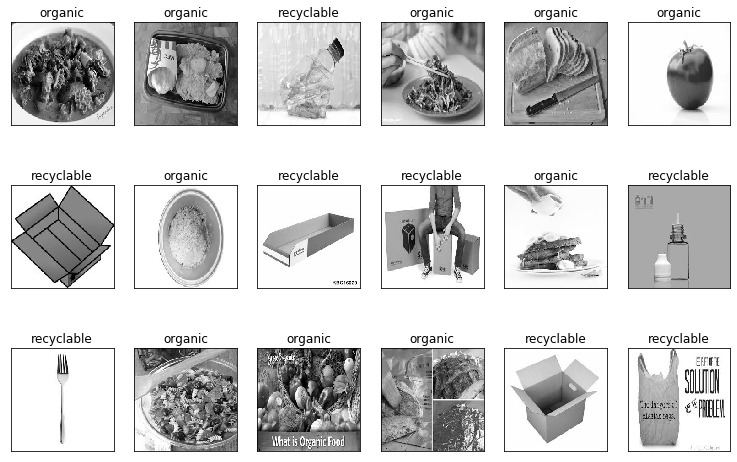

In [20]:
#take a smaller sample of the dataset
sample = random.sample(range(0, organic_imgs.shape[0]), k = 1500)
org_sample = organic_imgs[sample]
org_target_sample = org_target[sample]

sample = random.sample(range(0, recyclable_imgs.shape[0]), k = 1500)
rec_sample = recyclable_imgs[sample]
rec_target_sample = rec_target[sample]

#combine both dataframes
X = np.concatenate((org_sample, rec_sample))
y = np.concatenate((org_target_sample, rec_target_sample))

print("X shape: ",X.shape)
print("y shape: ", y.shape)
plot_gallery(X,y, h, w)

In [22]:
from sklearn.decomposition import PCA
import pickle

n_components = 300

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenvalues_pca = pca.components_.reshape((n_components, h, w))

#pickle dump
pickle.dump(eigenvalues_pca, open('eigenvalues_pca.p', 'wb'))

CPU times: user 42.3 s, sys: 1.05 s, total: 43.4 s
Wall time: 8.2 s


In [ ]:
#load pca from pickle
eigenvalues_pca = pickle.load(open('eigenvalues_pca.p','rb'))

In [23]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [24]:
plot_explained_variance(pca)

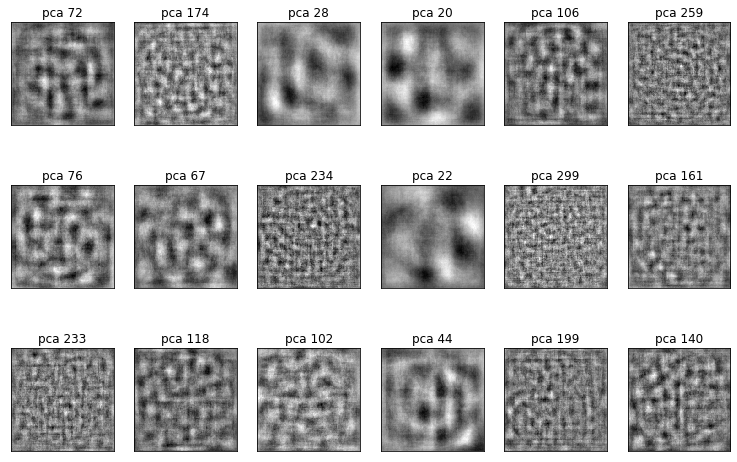

In [25]:
eigenvalues_pca_titles = ["pca %d" % i for i in range(eigenvalues_pca.shape[0])]
plot_gallery(eigenvalues_pca, eigenvalues_pca_titles, h, w)

In [26]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 4    
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

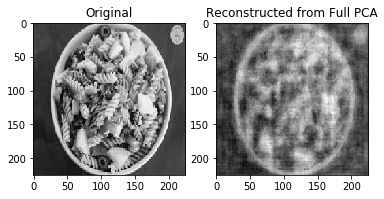

In [27]:
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

In [29]:
from sklearn.decomposition import KernelPCA

n_components = 300

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=12, # very sensitive to the gamma parameter,
                remove_zero_eig=True,n_jobs=-1)  
%time kpca.fit(X.copy())

CPU times: user 2min 14s, sys: 3min 6s, total: 5min 21s
Wall time: 54.5 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=12, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=300, n_jobs=-1,
          random_state=None, remove_zero_eig=True, tol=0)

In [30]:
#pickle dump
pickle.dump(kpca, open( 'kpca.p', 'wb' ))

In [31]:
# widgets example
from ipywidgets import widgets  # make this interactive!

widgets.interact(lambda x: print(x),x=(0,5,1))

interactive(children=(IntSlider(value=2, description='x', max=5), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(x)>

In [37]:
import warnings
# warnings.simplefilter('ignore', DeprecationWarning)
# warnings.simplefilter("always",DeprecationWarning)



def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    #reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
#     plt.subplot(1,4,3)
#     plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
#     plt.title('Randomized PCA')
#     plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,X.shape[0]-1,1),__manual=True)

interactive(children=(IntSlider(value=1499, description='idx_to_reconstruct', max=2999), Output()), _dom_class…

<function __main__.plt_reconstruct(idx_to_reconstruct)>